In [ ]:
from IPython.core.display import HTML
from python_tricks import array_to_cmap
from bayescorner import bayescorner
from IPython.display import Image
import stan_utility
from astropy.cosmology import Planck15 as cosmo
from betagen import betagen
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import pandas as pd
from chainconsumer import ChainConsumer

%matplotlib notebook
plt.style.use("mike")
jtplot.style(context="notebook", fscale=1.2, grid=False, ticks=True)

dark, dark_highlight, mid, mid_highlight, light, light_highlight = betagen("#8F2727")

blue = "#5DADE2"
green = "#58D68D"
yellow = "#F7DC6F"
red = "#F1948A"

import warnings
warnings.simplefilter("ignore")

# Supernovae Cosmology

Our goal is to use the observed brightness of Type Ia Sne (assuming they are standard candles).

When an Sne is detected, one measures and wavelength dependent light curve and fits it with the so-called SALTII 
model. We obtain from SALTII several parameters. Of high importance is the B-band magnitude. This is a proxy for the apparent brightness of the Sne. 


SALTII is an empirically derived template which is fit to the multiwavelength photometric light curves. It has other free parameters such as the color shift (c) and the stretch (x1) of of the light curve. 

You can get the data [here](http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html).

In [7]:
Image(
    url="http://supernovae.in2p3.fr/salt/lib/exe/fetch.php?cache=&media=sn2011fe2.png"
)

## The JLA Data set

In [8]:
jla_data_set = pd.read_table("jla_lcparams.txt")

In [9]:
jla_data_set

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,...,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
0,03D1au,0.503084,0.504300,0,23.001698,0.088031,1.273191,0.150058,-0.012353,0.030011,...,0.110500,52909.745220,0.214332,0.000790,0.000440,-0.000030,1,36.043210,-4.037469,0.001697
1,03D1aw,0.580724,0.582000,0,23.573937,0.090132,0.974346,0.273823,-0.025076,0.036691,...,0.088000,52902.898002,0.352732,0.002823,0.000415,0.001574,1,36.061634,-4.517158,0.000843
2,03D1ax,0.494795,0.496000,0,22.960139,0.088110,-0.728837,0.102069,-0.099683,0.030305,...,0.112500,52915.923670,0.111634,0.000542,0.000475,-0.000024,1,36.097287,-4.720774,0.001692
3,03D1bp,0.345928,0.347000,0,22.398137,0.087263,-1.155110,0.112834,-0.040581,0.026679,...,0.123500,52920.249015,0.102828,0.001114,0.000616,0.000295,1,36.657235,-4.838779,-0.000270
4,03D1co,0.677662,0.679000,0,24.078115,0.098356,0.618820,0.404295,-0.039380,0.067403,...,0.284000,52954.458342,0.454715,0.011857,0.000780,0.005898,1,36.567748,-4.935050,-0.002855
5,03D1dt,0.610712,0.612000,0,23.285241,0.092877,-1.161563,1.641345,-0.094943,0.049652,...,0.092000,52962.253197,0.976562,0.029671,0.000947,0.044357,1,36.629968,-4.052341,0.000026
6,03D1ew,0.866494,0.868000,0,24.353678,0.106037,0.376409,0.348004,-0.063269,0.067817,...,0.805000,52991.741625,0.665126,0.003181,-0.001601,0.004093,1,36.058795,-4.665852,-0.017996
7,03D1fc,0.330932,0.332000,0,21.861412,0.086437,0.650394,0.118542,-0.017577,0.023794,...,0.036000,53002.763813,0.104433,0.001006,0.000527,0.000540,1,36.431648,-4.144059,-0.000526
8,03D1fq,0.798566,0.800000,0,24.510389,0.101777,-1.056666,0.406837,-0.055975,0.064955,...,0.127000,52999.213046,0.655817,0.005897,-0.001115,0.003551,1,36.731935,-4.302217,-0.011577
9,03D3aw,0.449562,0.449000,0,22.667126,0.091912,0.810113,0.232169,-0.085962,0.038205,...,0.034000,52767.328075,0.200656,0.005474,0.000792,0.000662,1,215.223049,52.605624,0.001400


### The data

<IPython.core.display.Javascript object>


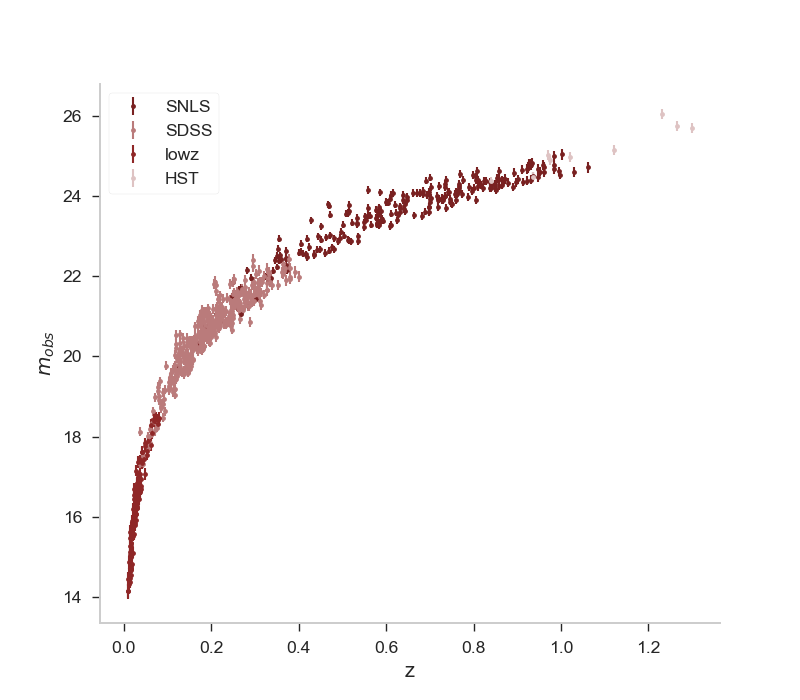

Text(0, 0.5, '$m_{obs}$')

In [10]:
snls = jla_data_set["set"] == 1
sdss = jla_data_set["set"] == 2
lowz = jla_data_set["set"] == 3
hst = jla_data_set["set"] == 4

survery_names = ["SNLS", "SDSS", "lowz", "HST"]

fig, ax = plt.subplots()

colors = [dark_highlight,mid, dark, light]

for i, ds in enumerate([snls, sdss, lowz, hst]):

    ax.errorbar(
        jla_data_set.zcmb[ds],
        jla_data_set.mb[ds],
        yerr=jla_data_set.dmb[ds],
        fmt=".",
        label=survery_names[i],
        color=colors[i]
    )
ax.legend()


ax.set_xlabel("z")
ax.set_ylabel(r"$m_{obs}$")

## What we measure and what we think we measure

Assuming that every Sn has the same intrinsic B-band magnitude, $M_B$, the observed distance modulus, $\mu_B$ can can be computed using the measured apparent magnitude, $m_B$ via:

$$\mu_{\mathrm{obs}}=m_{B}-M_{B}$$

If we wanted to *predict* the distance modulus, $\mu_{C}$, at some redshift, $z$, we can compute it from cosmology such via: 

$$\mu_{C}=5 \log \left[\frac{d_{L}}{10 \mathrm{pc}}\right]$$

$$d_{L}=(1+z) \frac{c}{H_{0}} \int_{0}^{z} \frac{d z^{\prime}}{E\left(z^{\prime}\right)}$$

$$E(z)=\sqrt{\Omega_{m}\left(1+z^{\prime}\right)^{3}+\Omega_{k}\left(1+z^{\prime}\right)^{2}+\Omega_{\Lambda}\left(1+z^{\prime}\right)^{3(1+w)}}$$


<IPython.core.display.Javascript object>


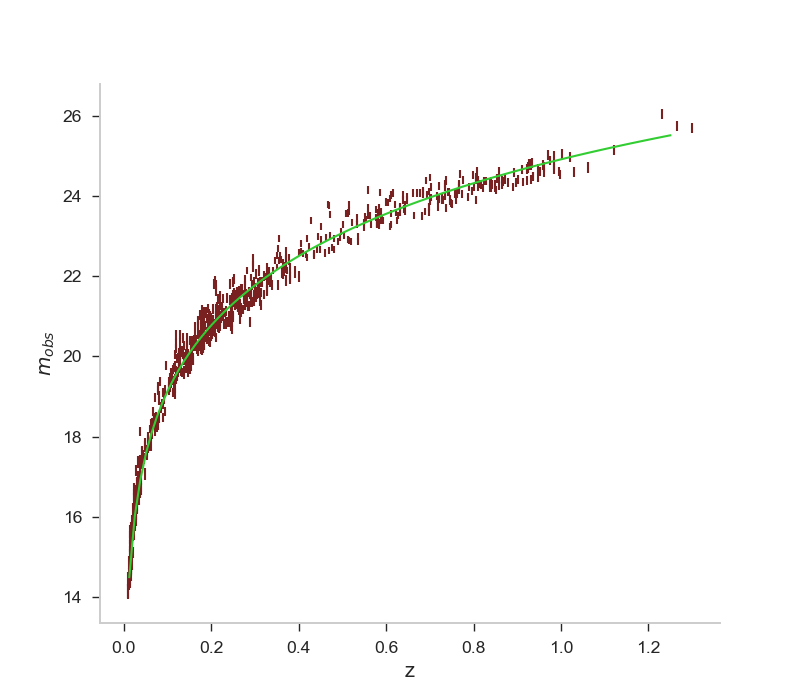

In [11]:
fig, ax = plt.subplots()

ax.errorbar(
    jla_data_set.zcmb, jla_data_set.mb, yerr=jla_data_set.dmb, fmt="_", color=dark_highlight
)

ax.set_xlabel("z")
ax.set_ylabel(r"$m_{obs}$")


zgrid = np.linspace(0, 1.25, 100)

ax.plot(zgrid, cosmo.distmod(zgrid).value - 19.25, color="limegreen")

# Fitting (the old way)

So it appears we can simply minimize the distance between $\mu_B$ and $\mu_C$. We can right the likelihood such that

$$\chi^{2}=\left(\mu_{\mathrm{obs}}-\mu_{C}\right)^{\dagger} C_{\mu}^{-1}\left(\mu_{\mathrm{obs}}-\mu_{C}\right)$$

where we can iterate the cosmological parameters to get as close a match as possible between data and prediction.

Let's examine this in Stan!


## Fit results

In [12]:
fit1 = stan_utility.StanSavedFit("sncosmo_simple_fit.h5")

<IPython.core.display.Javascript object>


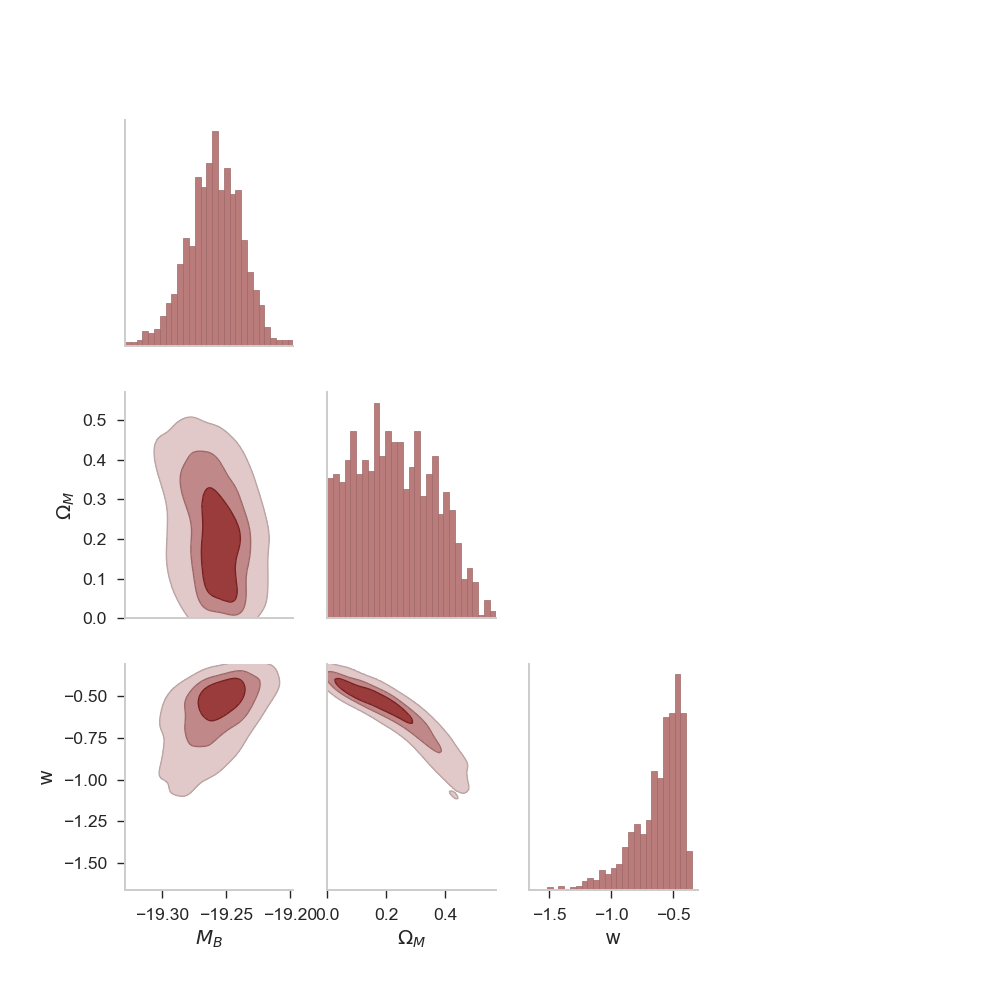

In [13]:
fig = bayescorner(
    params=[fit1.Om, fit1.w, fit1.M0],
    param_names=[r"$\Omega_M$", "w", r"$M_B$"],
    #figsize=(12, 8),
)

<IPython.core.display.Javascript object>


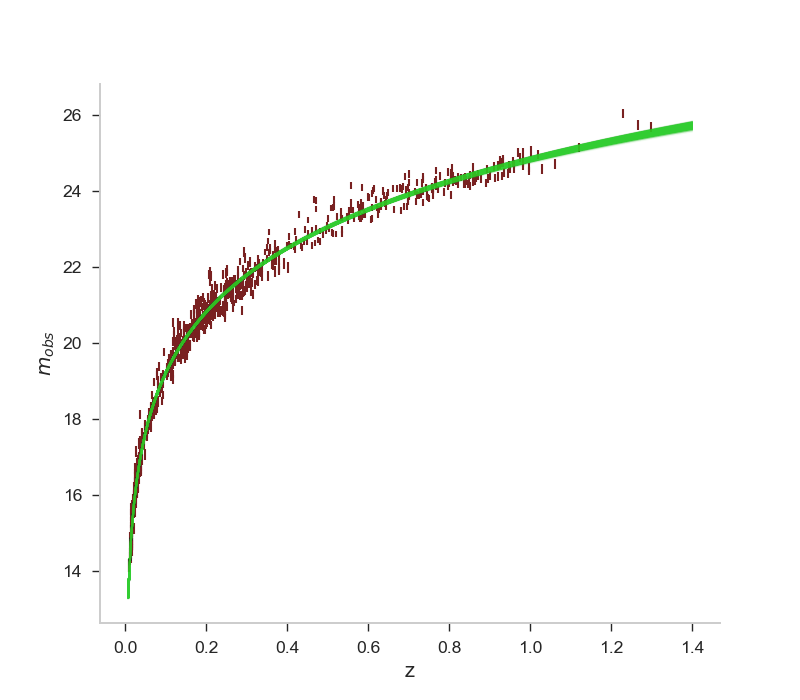

In [14]:
fig, ax = plt.subplots()


ax.errorbar(
    jla_data_set.zcmb, jla_data_set.mb, yerr=jla_data_set.dmb, fmt="_", color=dark_highlight
)

ax.set_xlabel("z")
ax.set_ylabel(r"$m_{obs}$")

zgrid = np.linspace(0, 1.25, 100)

n_model = 200
z_model = np.linspace(0, 1.4, n_model)

for mb in fit1.mb_curve[::1]:
    ax.plot(z_model, mb, color='limegreen', alpha=0.05)

# The Philips Correction 

Very early on, astronomers realized that Sn were not perfect standard candles. Soon, they realized that corrections to the observed distance modulus were needed. This takes the form of the Philips correction:


$$\mu_{\mathrm{obs}}=m_{B}+\alpha x_{1}-\beta c-M_{B}$$

Now, $\alpha$ and $\beta$ are determined **during** the fit along with cosmology and are thus dependent on **the cosmological model from which they were determined!**


For now, we simply place uniform priors on $\alpha$ and $\beta$

Let's now throw this into Stan and see what we get. 






In [15]:
fit2 = stan_utility.StanSavedFit('sncosmo_bias_fit.h5')

<IPython.core.display.Javascript object>


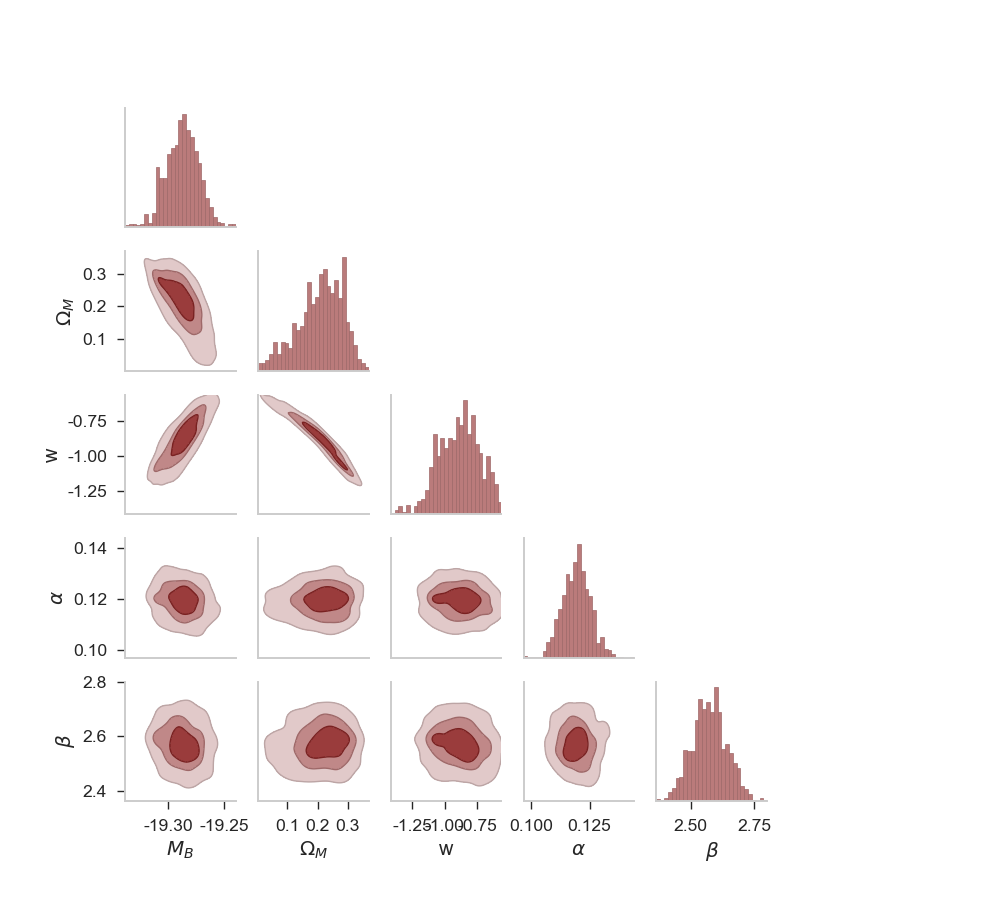

In [16]:
fig = bayescorner(
    params=[fit2.Om, fit2.w, fit2.alpha, fit2.beta, fit2.M0],
    param_names=[r"$\Omega_M$", "w", r"$\alpha$", r"$\beta$", r"$M_B$"],
    figsize=(10, 9),
)

<IPython.core.display.Javascript object>


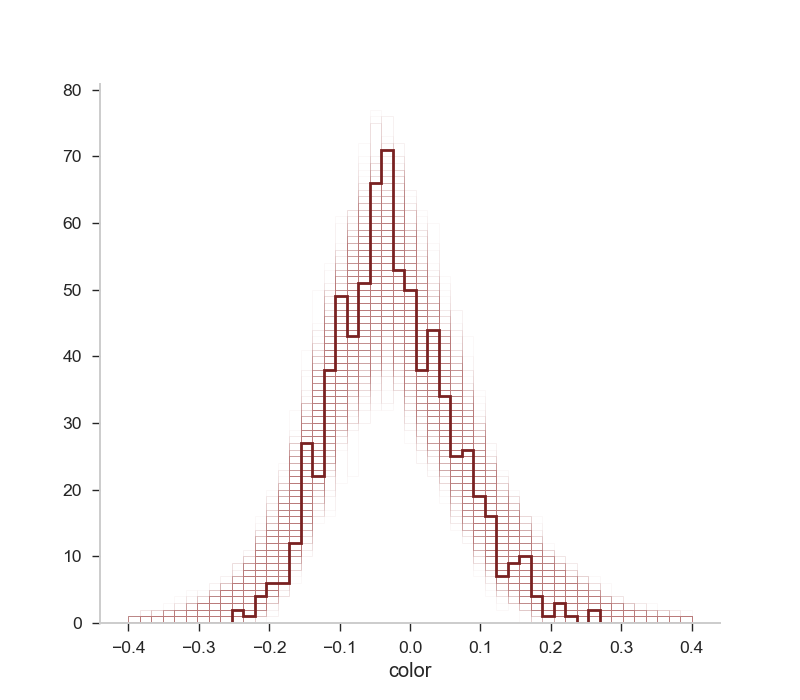

Text(0.5, 0, 'color')

In [17]:
bins = np.linspace(-0.4, 0.4, 50)

fig, ax = plt.subplots()

for c in fit2.c_obs_ppc[::1]:

    ax.hist(c, bins=bins, color=mid, alpha=0.05, histtype="step", lw=0.7)

ax.hist(jla_data_set.color, bins=bins, color=dark_highlight, histtype="step", lw=2)


ax.set_xlabel("color")

In [ ]:
bins = np.linspace(-4, 3, 50)

fig, ax = plt.subplots()

for c in fit2.x1_obs_ppc[::1]:

    ax.hist(c, bins=bins, color=mid, alpha=0.05, histtype="step", lw=0.7)

ax.hist(jla_data_set.x1, bins=bins, color=dark_highlight, histtype="step", lw=2)

ax.set_xlabel("x1")

In [ ]:
bins = np.linspace(11, 30, 50)

fig, ax = plt.subplots()

for c in fit2.m_obs_ppc[::1]:

    ax.hist(c, bins=bins, color=mid, alpha=0.05, histtype="step", lw=0.7)

ax.hist(jla_data_set.mb, bins=bins, color=dark_highlight, histtype="step", lw=2)
ax.set_xlabel("mb")

# The (almost) right way

It seems we have a better fit more inline with what we expect. But we haven't discussed selection effects or bias.

Let's have a look at the color and stretch parameters ranked by the size of their errors.

<IPython.core.display.Javascript object>


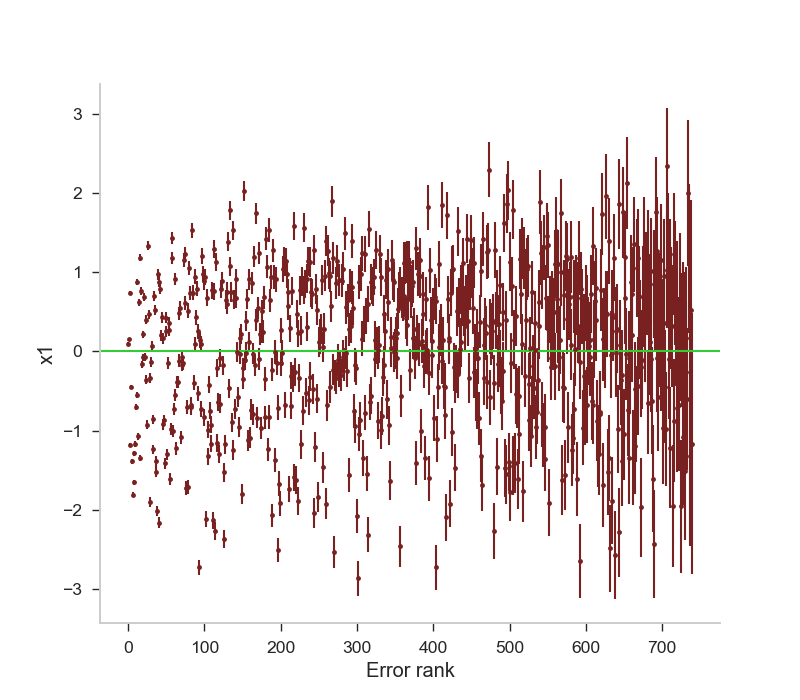

Text(0.5, 0, 'Error rank')

In [18]:
sort_idx = np.argsort(np.array(jla_data_set.dx1))

fig, ax = plt.subplots()


ax.errorbar(
    range(len(sort_idx)),
    jla_data_set.x1[sort_idx],
    yerr=jla_data_set.dx1[sort_idx],
    fmt=".",
    color=dark_highlight,
)
ax.axhline(0, color='limegreen')

ax.set_ylabel("x1")
ax.set_xlabel("Error rank")

<IPython.core.display.Javascript object>


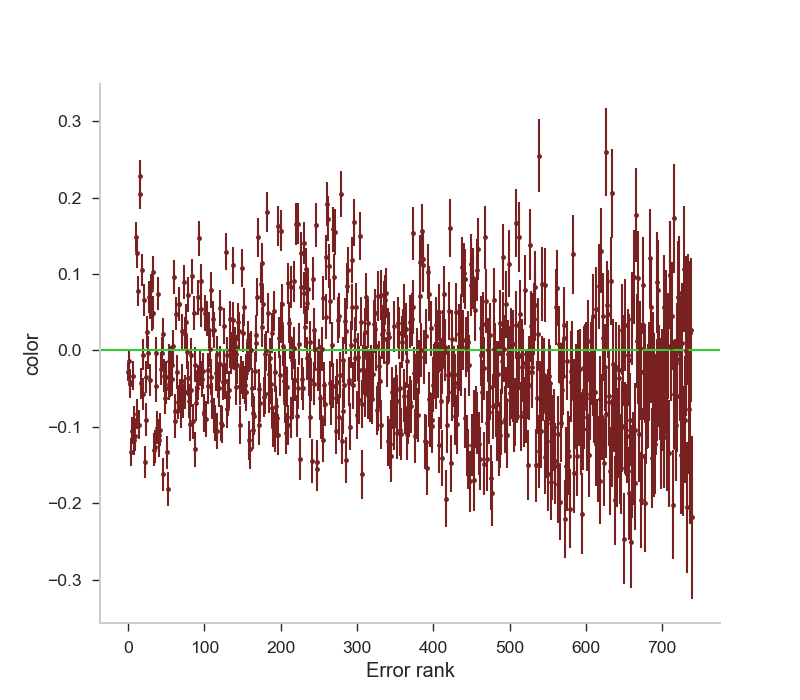

Text(0.5, 0, 'Error rank')

In [19]:
sort_idx = np.argsort(np.array(jla_data_set.dcolor))

fig, ax = plt.subplots()

ax.errorbar(
    range(len(sort_idx)),
    jla_data_set.color[sort_idx],
    yerr=jla_data_set.dcolor[sort_idx],
    fmt=".",
    color=dark_highlight,
)
ax.axhline(0, color="limegreen")

ax.set_ylabel("color")
ax.set_xlabel("Error rank")

## Malmquist Bias

This is an example of Malmquist-like bias,  i.e., the data scatter more than their error bars. We can fits this by assuming that the parameters come from the same hyper-distribution. 

$$c_{true} \sim \mathcal{N}(\mu_c, \tau_c)$$
$$x1_{true} \sim \mathcal{N}(\mu_{x1}, \tau_{x1})$$


Thus, the color and stretch parameters "learn" what they should be from the other Sne. This is a form of hierarchical model. We allow the mean and std of the hyper-distributions to be free parameters during the fit. 


In [20]:
fit3 = stan_utility.StanSavedFit('sncosmo_fit.h5')

<IPython.core.display.Javascript object>


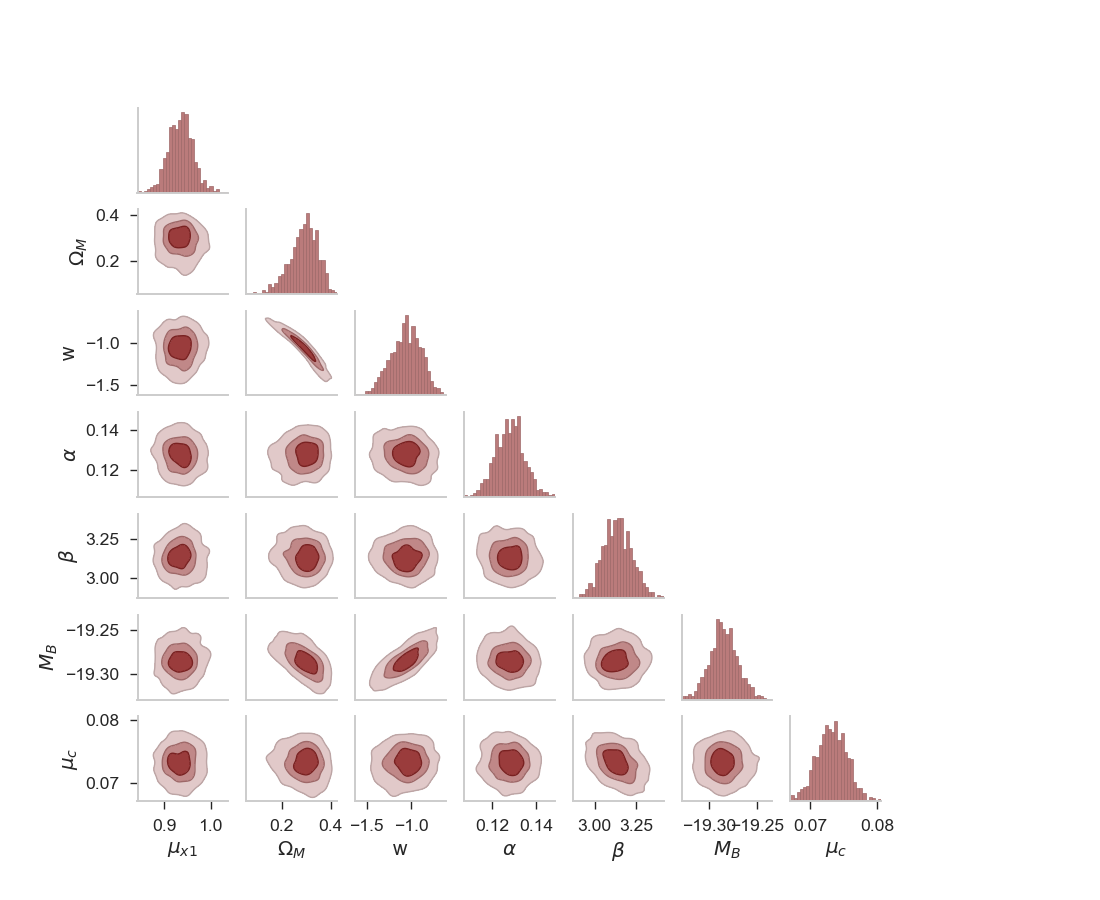

In [21]:
fig = bayescorner(
    params=[fit3.Om, fit3.w, fit3.alpha, fit3.beta, fit3.M0, fit3.Rc, fit3.Rx],
    param_names=[
        r"$\Omega_M$",
        "w",
        r"$\alpha$",
        r"$\beta$",
        r"$M_B$",
        r"$\mu_c$",
        r"$\mu_{x1}$",
    ],
    figsize=(11, 9),
)

<IPython.core.display.Javascript object>


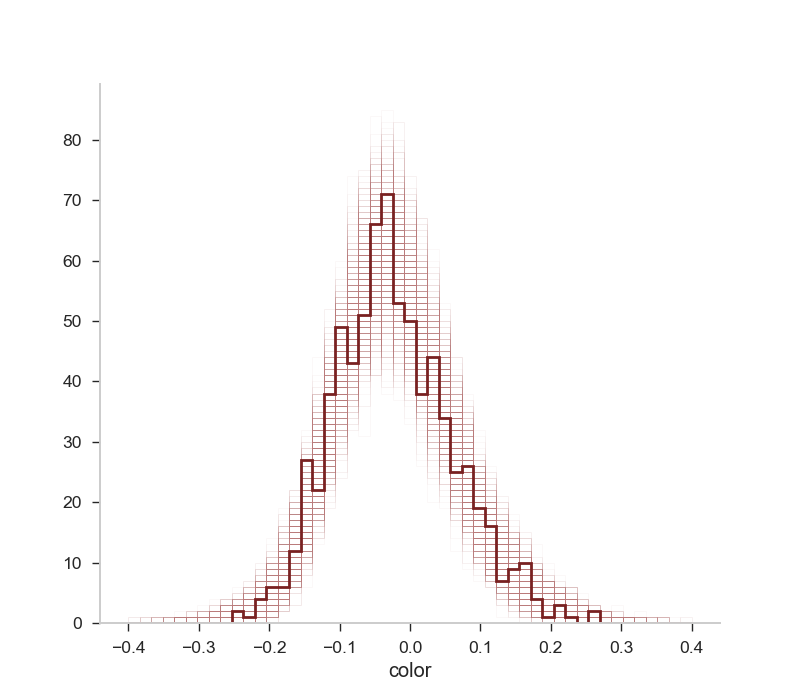

Text(0.5, 0, 'color')

In [22]:
bins = np.linspace(-0.4, 0.4, 50)

fig, ax = plt.subplots()

for c in fit3.c_obs_ppc[::1]:

    ax.hist(c, bins=bins, color=mid, alpha=0.05, histtype="step", lw=0.7)

ax.hist(jla_data_set.color, bins=bins, color=dark_highlight, histtype="step", lw=2);


ax.set_xlabel("color")

In [ ]:
bins = np.linspace(-4, 3, 50)

fig, ax = plt.subplots()

for c in fit3.x1_obs_ppc[::1]:

    ax.hist(c, bins=bins, color=mid, alpha=0.05, histtype="step", lw=0.7)

ax.hist(jla_data_set.x1, bins=bins, color=dark_highlight, histtype="step", lw=2)
ax.set_xlabel("x1")

## Does it matter?

We did a lot of work and introduced a lot of structure into our model. Maybe you think it is *fancy* and not need. Perhaps you get the same answer by just doing the simple with our beloved $\chi^2$?

Let's examine a few things. 

### The hierarchical structure's affect on the latent parameters.

We can see how far our latent observed parameters moved from the measured data by looking at their *pull*.

<IPython.core.display.Javascript object>


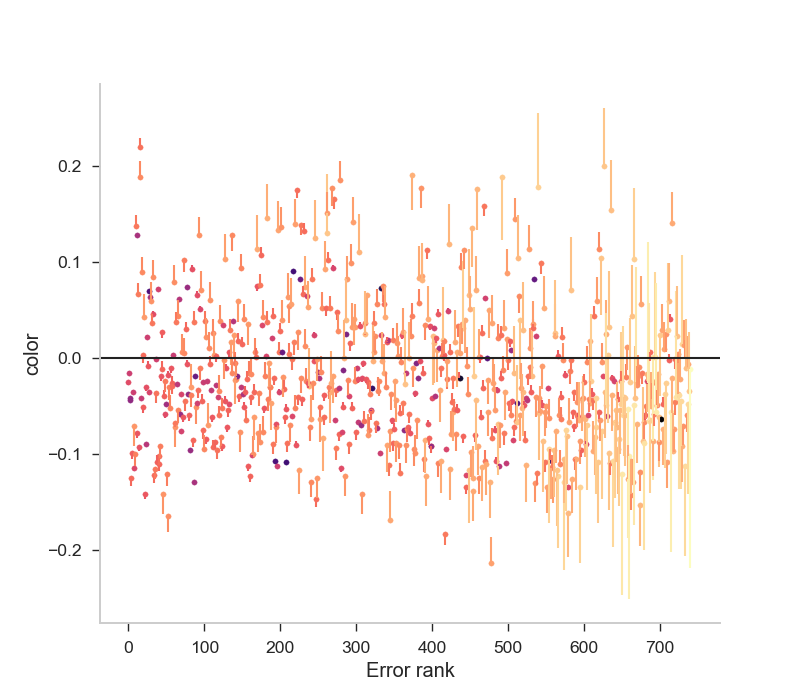

Text(0.5, 0, 'Error rank')

In [23]:
fig, ax = plt.subplots()

sort_idxs = np.argsort(np.array(jla_data_set.dcolor))


median_c_latent = np.median(fit3.c_latent, axis=0)


pulls = np.abs(jla_data_set.color[sort_idxs] - median_c_latent[sort_idxs])


_, colors = array_to_cmap(pulls, cmap="magma", use_log=True)

for i, sort_idx in enumerate(sort_idxs):

    ax.vlines(
        i, jla_data_set.color[sort_idx], median_c_latent[sort_idx], colors=colors[i]
    )
    ax.scatter(i, median_c_latent[sort_idx], color=colors[i], s=15, zorder=-1)
ax.axhline(0, color="k")


ax.set_ylabel("color")
ax.set_xlabel("Error rank")

But maybe we got the same thing from not assuming a more connected structure?

<IPython.core.display.Javascript object>


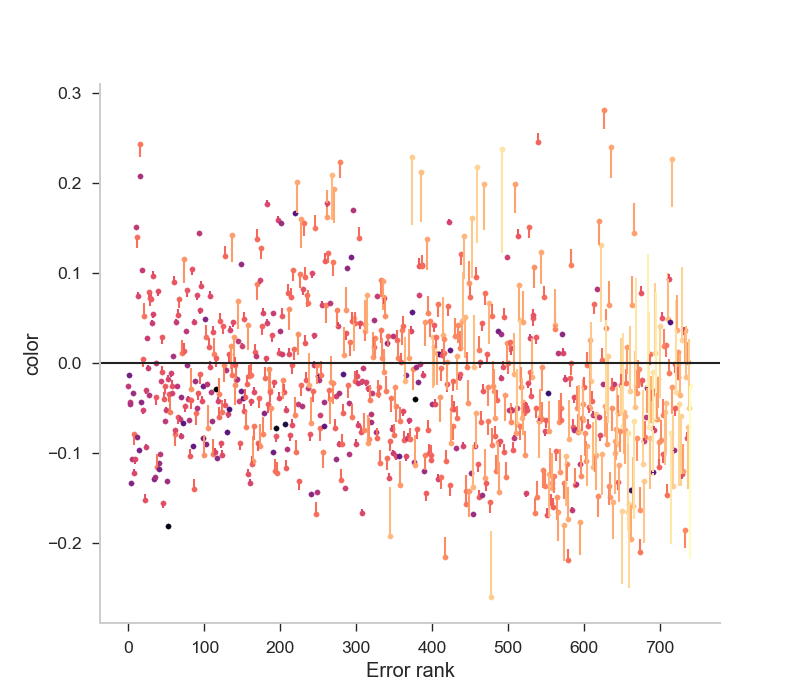

Text(0.5, 0, 'Error rank')

In [24]:
fig, ax = plt.subplots()

sort_idxs = np.argsort(np.array(jla_data_set.dcolor))


median_c_latent = np.median(fit2.c_latent, axis=0)


pulls = np.abs(jla_data_set.color[sort_idxs] - median_c_latent[sort_idxs])


_, colors = array_to_cmap(pulls, cmap="magma", use_log=True)

for i, sort_idx in enumerate(sort_idxs):

    ax.vlines(
        i, jla_data_set.color[sort_idx], median_c_latent[sort_idx], colors=colors[i]
    )
    ax.scatter(i, median_c_latent[sort_idx], color=colors[i], s=15, zorder=-1)
ax.axhline(0, color="k")


ax.set_ylabel("color")
ax.set_xlabel("Error rank")

**Not entirely!** If we histogram our latent parameters from the two fits, we will see that we being to correct for the bias inherent in our observations.

<IPython.core.display.Javascript object>


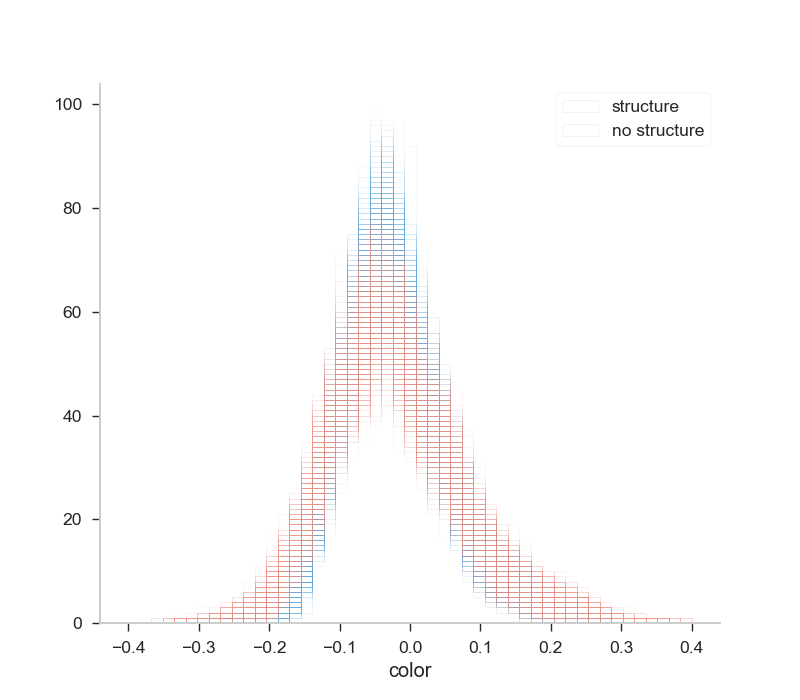

In [25]:
fig, ax = plt.subplots()


bins = np.linspace(-0.4, 0.4, 50)


for c in fit3.c_latent[1:]:

    ax.hist(c, bins=bins, color=blue, alpha=0.05, histtype="step", lw=0.7,)


ax.hist( fit3.c_latent[0], bins=bins, color="k", alpha=0.05, histtype="step", lw=0.7,label='structure')   
    
for c in fit2.c_latent[1:]:

    ax.hist(c, bins=bins, color=red, alpha=0.05, histtype="step", lw=0.7)
    

ax.hist( fit2.c_latent[0], bins=bins, color="k", alpha=0.05, histtype="step", lw=0.7,label='no structure')    
    
ax.set_xlabel('color')

ax.legend()

In [ ]:
fig, ax = plt.subplots()

sort_idxs = np.argsort(np.array(jla_data_set.dx1))


median_x1_latent = np.median(fit.x1_latent, axis=0)


pulls = np.abs(jla_data_set.x1[sort_idxs] - median_x1_latent[sort_idxs])


_, colors = array_to_cmap(pulls, cmap="viridis", use_log=True)

for i, sort_idx in enumerate(sort_idxs):

    ax.vlines(
        i, jla_data_set.x1[sort_idx], median_x1_latent[sort_idx], colors=colors[i]
    )
    ax.scatter(i, median_x1_latent[sort_idx], color=colors[i], s=15, zorder=-1)
ax.axhline(0, color="k")


ax.set_ylabel("x1")
ax.set_xlabel("Error rank")

# Putting it all together

What matters now is how the predictions from each of the modeling choices compare to one another.
Let's plot them all together.


<IPython.core.display.Javascript object>


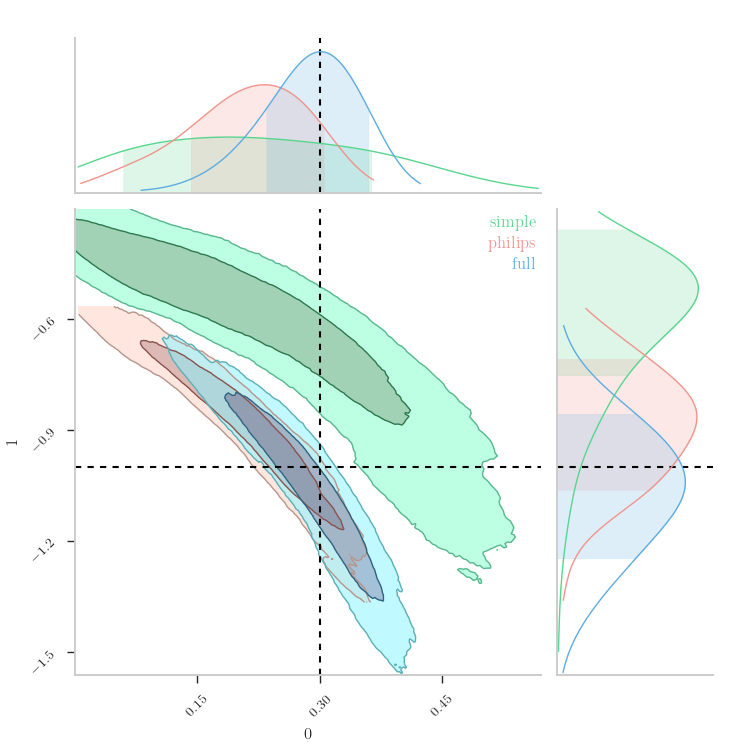

In [26]:
c = ChainConsumer()
c.add_chain([fit1.Om,fit1.w],smooth=True,kde=True, name='simple')#.add_chain(d2).add_chain(d3)
c.add_chain([fit2.Om,fit2.w],smooth=True,kde=True, name='philips')
c.add_chain([fit3.Om,fit3.w],smooth=True,kde=True, name='full')

c.configure(colors=[green,red,blue], shade=True, shade_alpha=0.5, bar_shade=True)
fig = c.plotter.plot(truth=[0.3, -1.])
fig.set_size_inches(4.5 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

In [ ]:
fig, ax = plt.subplots()




ax.scatter(fit1.Om, fit1.w, c=yellow, s=45, alpha=0.25, label="simple")

ax.scatter(fit2.Om, fit2.w, c=blue, s=45, alpha=0.25, label="Philips")

ax.scatter(fit3.Om, fit3.w, c=green, s=45, alpha=0.25, label="full")


ax.set_xlabel(r"$\Omega_{M}$")
ax.set_ylabel(r"$w$")

ax.axvline(0.3, color="k")
ax.axhline(-1, color="k")

ax.legend()